In [1]:
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.dates import DateFormatter
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot
import functions_profiles
import functions_upwelling_depth
import functions_velocity

from salishsea_tools import nc_tools, viz_tools
from salishsea_tools import gsw_calls

import xarray as xr

In [98]:
path = '/ocean/imachuca/Canyons/results_mackenzie/idealized/upwelling_events/'; cfg = 'eventB_pulse10'
gridT = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_T.nc')
gridU = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_U.nc')
gridV = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_V.nc')
gridW = xr.open_dataset(path+cfg+'/GYRE_1h_00010101_00010120_grid_W.nc')
sal = gridT['vosaline']
tem = gridT['votemper']
U = gridU['vozocrtx']
V = gridV['vomecrty']
utau = gridU['sozotaux']
vtau = gridV['sometauy']
vE = gridW['veddyvisc']
deps = gridW['depthw']
lats = gridW['nav_lat']

In [3]:
bathy_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_05.nc')
bathy = bathy_file['Bathymetry']
coord_lats = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_02.nc')['nav_lat'][:]

# Eddy viscosity in domain at time and depth

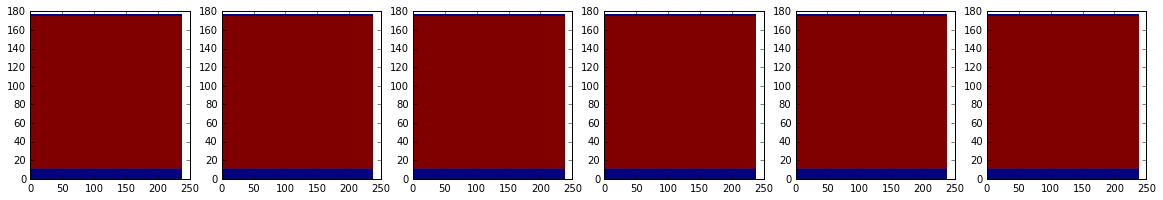

In [4]:
fig, ax = plt.subplots(1,6,figsize=(20,3), sharex=True)
for t, d, i in zip([200,203,206,200,203,206], [0,0,0,1,1,1], np.arange(6)):
    p = ax[i].pcolor(vE[t,d,:,:], vmin = 0, vmax=0.000105)

# Wind stress and eddy viscosity

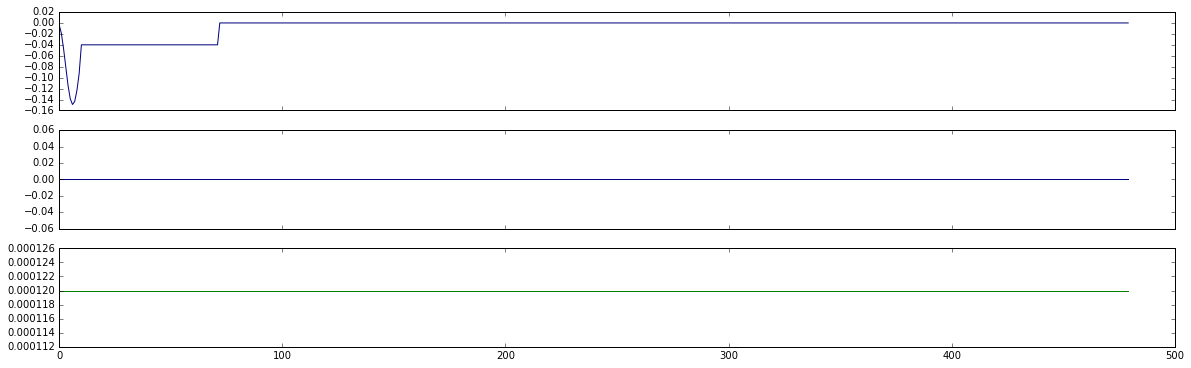

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(20,6), sharex=True)
ax1.plot(utau[:,100,100], c='navy')
ax2.plot(vtau[:,100,100], c='navy')
ax3.plot(vE[:,0,100,100], c='y')
ax3.plot(vE[:,2,100,100], c='r')
ax3.plot(vE[:,4,100,100], c='b')
ax3.plot(vE[:,7,100,100], c='g')

# Coriolis parameter

$$f(\lambda)= 2 \Omega \sin(\lambda)$$

$$\Omega = \frac{2 \pi}{24 hours}$$

The average latitude at the northern boundary is 70.943. The average coriolis parameter is 0.0001374. fpar was calculated at all points along the boundary.

In [116]:
indN = -2
latN = lats[indN,:]
omega = (2 * np.pi) / (24 * 60 * 60)
fpar = 2 * omega * np.sin(np.deg2rad(latN))

# Ekman layer thickness

$$\delta = \sqrt \frac{2\nu_E}{f}$$

In [12]:
vEN = vE[0,:,-2,:]
delta = np.sqrt((2 * vEN) / fpar)

In [21]:
fpar.shape, vEN.shape, delta.shape

((237,), (30, 237), (30, 237))

# Pressure driven component

$$ fu_g = - \frac{1}{\rho} \frac{\partial p}{\partial y} $$

$$ -fv_g = - \frac{1}{\rho} \frac{\partial p}{\partial x} $$

Gives:
$$ u_g = - \frac{1}{\rho f} \frac{\partial p}{\partial y} $$

$$ v_g = \frac{1}{\rho f} \frac{\partial p}{\partial x} $$

Or:

$$u_g = - \frac{1}{\rho f}\frac{\partial}{\partial y} \int_{H}^{0} g(\lambda ,z) \rho(z) dz - \frac{g}{f} \frac{\partial \zeta}{\partial y}$$

$$v_g = \frac{1}{\rho f}\frac{\partial}{\partial x} \int_{H}^{0} g(\lambda ,z) \rho(z) dz + \frac{g}{f} \frac{\partial \zeta}{\partial x}$$

https://ocw.mit.edu/courses/mechanical-engineering/2-011-introduction-to-ocean-science-and-engineering-spring-2006/readings/geostrophic.pdf

https://marine.rutgers.edu/dmcs/ms501/2004/Notes/Wilkin20041101.htm

In [125]:
z = np.transpose(np.tile(-1 * deps, (237, 1)))
l = np.tile(latN, (30, 1))
p = gsw_calls.generic_gsw_caller('gsw_p_from_z.m', [z,l], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')

SA = sal[0, :, indN, :]
CT = tem[0, :, indN, :]
#rho = gsw_calls.generic_gsw_caller('gsw_rho_CT_exact.m', [SA,CT,p], matlab_gsw_dir='/ocean/rich/home/matlab/gsw3')


depN.shape, latN.shape, z.shape, l.shape, p.shape, SA.shape, CT.shape

((30,), (237,), (30, 237), (30, 237), (30, 237), (30, 237), (30, 237))

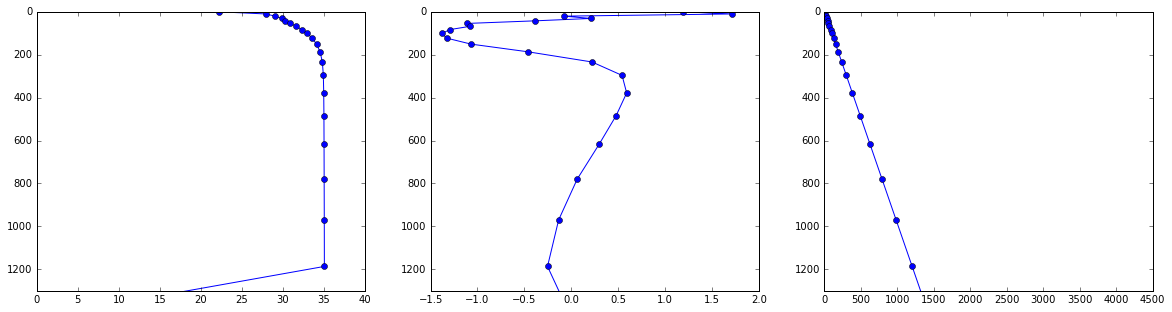

In [119]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
for var, i in zip([SA, CT, p], np.arange(3)):
    ax[i].plot(var[:,100], deps, marker='o')
    ax[i].set_ylim([1300, 0])